<a href="https://colab.research.google.com/github/AbduzZami/ColabNotebooks/blob/main/dense%20121%20gl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shadmansobhan_combined_dataset_pt1_path = kagglehub.dataset_download('shadmansobhan/combined-dataset-pt1')
shadmansobhan_dataset_mp_review_path = kagglehub.dataset_download('shadmansobhan/dataset-mp-review')

print('Data source import complete.')


Using Colab cache for faster access to the 'combined-dataset-pt1' dataset.
Using Colab cache for faster access to the 'dataset-mp-review' dataset.
Data source import complete.


In [47]:
ENCODER_NAME='densenet121' # efficientnet_b0 efficientnet_b1 resnet50 densenet121 mobilenet_v2
NUM_CLASS_SEG=2
NUM_CLASS_CLS=2
MODE=1
DATASET_NAME='Combined_GI_Tract' #Combined_RBV Combined_GI_Tract
BATCH_SIZE= 2 if DATASET_NAME == 'Combined_RBV' else 64

In [48]:
!pip install torchinfo

In [49]:
# Standard libraries
import os
import shutil
import random
from pathlib import Path
import warnings
import time

warnings.filterwarnings("ignore")

# Image processing
import cv2
from PIL import Image

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader


# Torchvision
from torchvision.models.efficientnet import efficientnet_b0, EfficientNet_B0_Weights

import torch
import torchvision.models as models
from torchvision.models import (
    resnet50, ResNet50_Weights,
    densenet121, DenseNet121_Weights,
    mobilenet_v2, MobileNet_V2_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
    inception_v3, Inception_V3_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    efficientnet_b1, EfficientNet_B1_Weights
)




# Albumentations
import albumentations as album
from albumentations.pytorch import ToTensorV2

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Model Define

In [50]:
# # SeparableConv2d remains unchanged
# class SeparableConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
#         super().__init__()
#         self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
#         self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

#     def forward(self, x):
#         return self.pointwise(self.depthwise(x))

# # ASPP remains unchanged
# class ASPP(nn.Module):
#     def __init__(self, in_channels, out_channels, atrous_rates):
#         super().__init__()
#         modules = [
#             nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             )
#         ]
#         for rate in atrous_rates:
#             modules.append(nn.Sequential(
#                 SeparableConv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             ))
#         modules.append(nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(in_channels, out_channels, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         ))
#         self.convs = nn.ModuleList(modules)
#         self.project = nn.Sequential(
#             nn.Conv2d((len(atrous_rates) + 2) * out_channels, out_channels, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(0.5)
#         )

#     def forward(self, x):
#         size = x.shape[2:]
#         res = [F.interpolate(conv(x), size=size, mode='bilinear', align_corners=True) if i == len(self.convs)-1 else conv(x) for i, conv in enumerate(self.convs)]
#         return self.project(torch.cat(res, dim=1))

# # MFF Block
# class MFFBlock(nn.Module):
#     def __init__(self, in_channels_low, in_channels_high, out_channels):
#         super().__init__()
#         self.low_proj = nn.Conv2d(in_channels_low, out_channels, 1, bias=False)
#         self.high_proj = nn.Conv2d(in_channels_high, out_channels, 1, bias=False)
#         self.fusion = nn.Sequential(
#             nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(out_channels, out_channels // 8, 1),
#             nn.ReLU(),
#             nn.Conv2d(out_channels // 8, out_channels, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, low_feat, high_feat):
#         high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=True)
#         low_feat = self.low_proj(low_feat)
#         high_feat = self.high_proj(high_feat)
#         x = low_feat + high_feat
#         x = self.fusion(x)
#         return x * self.se(x)

# # CAFSE Block
# class CAFSEBlock(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.coarse = nn.Sequential(
#             nn.Conv2d(channels, channels, 3, padding=1),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(inplace=True)
#         )
#         self.fine = nn.Sequential(
#             nn.Conv2d(channels, channels, 1),
#             nn.BatchNorm2d(channels),
#             nn.Sigmoid()
#         )

#     def forward(self, decoder_feat, aspp_feat):
#         aspp_feat = F.interpolate(aspp_feat, size=decoder_feat.shape[2:], mode='bilinear', align_corners=True)
#         coarse = self.coarse(aspp_feat)
#         fine = self.fine(decoder_feat)
#         return decoder_feat + coarse * fine

# # Decoder remains unchanged
# class Decoder(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 48, 1, bias=False),
#             nn.BatchNorm2d(48),
#             nn.ReLU(inplace=True)
#         )
#         self.fuse = nn.Sequential(
#             SeparableConv2d(96, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             SeparableConv2d(out_channels, out_channels, 3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(0.3)
#         )

#     def forward(self, x, low_level_feat):
#         x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=True)
#         x = self.conv1(x)
#         x = torch.cat([x, low_level_feat], dim=1)
#         return self.fuse(x)

# #Main model
# class DeepLabV3Plus(nn.Module):
#     def __init__(self, num_num_classes_seg_seg=1, num_num_classes_seg_cls=2, mode=1, output_stride=16, activation='sigmoid'):
#         super().__init__()
#         self.mode = mode
#         self.output_stride = output_stride

#         # backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
#         # backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
#         # backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         backbone = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
#         # backbone = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
#         # backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
#         # backbone = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         # backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
#         # backbone = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)

#         features = list(backbone.features.children())
#         if output_stride == 16:
#             self.low_level = nn.Sequential(*features[:3])
#             self.high_level = nn.Sequential(*features[3:])
#         else:
#             self.low_level = nn.Sequential(*features[:2])
#             self.high_level = nn.Sequential(*features[2:])

#         low_level_channels = 24 if output_stride == 16 else 16
#         self.low_proj = nn.Sequential(
#             nn.Conv2d(low_level_channels, 48, 1, bias=False),
#             nn.BatchNorm2d(48),
#             nn.ReLU(inplace=True)
#         )

#         atrous_rates = [6, 12, 18] if output_stride == 16 else [12, 24, 36]
#         self.aspp = ASPP(1280, 256, atrous_rates)
#         self.mff = MFFBlock(48, 256, 256)
#         self.decoder = Decoder(256, 256)
#         self.cafse = CAFSEBlock(256)
#         self.final_conv = nn.Conv2d(256, num_num_classes_seg_seg, 1)

#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Flatten(),
#             nn.Linear(1280, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, num_num_classes_seg_cls)
#         )

#         if activation == 'sigmoid':
#             self.activation = nn.Sigmoid()
#         elif activation == 'softmax2d':
#             self.activation = nn.Softmax2d()
#         else:
#             self.activation = None

#     def forward(self, x):
#         input_size = x.size()[2:]
#         low_feat = self.low_level(x)
#         high_feat = self.high_level(low_feat)
#         low_proj = self.low_proj(low_feat)

#         if self.mode == 0:
#             out = self.classifier(high_feat)
#             return out
#         elif self.mode == 1:
#             aspp_out = self.aspp(high_feat)
#             mff_out = self.mff(low_proj, aspp_out)
#             decoder_out = self.decoder(mff_out, low_proj)
#             cafse_out = self.cafse(decoder_out, aspp_out)
#             out = self.final_conv(cafse_out)
#             out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
#             if self.activation is not None:
#                 out = self.activation(out)
#             return out
#         else:
#             raise ValueError("Mode must be 0 (classification) or 1 (segmentation)")


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import (
    efficientnet_b0, EfficientNet_B0_Weights,
    efficientnet_b1, EfficientNet_B1_Weights,
    resnet50, ResNet50_Weights,
    densenet121, DenseNet121_Weights,
    mobilenet_v2, MobileNet_V2_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
    inception_v3, Inception_V3_Weights
)

# SeparableConv2d remains unchanged
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

# ASPP remains unchanged
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super().__init__()
        modules = [
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        ]
        for rate in atrous_rates:
            modules.append(nn.Sequential(
                SeparableConv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        modules.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))
        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d((len(atrous_rates) + 2) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)
        )

    def forward(self, x):
        size = x.shape[2:]
        res = [F.interpolate(conv(x), size=size, mode='bilinear', align_corners=True) if i == len(self.convs)-1 else conv(x) for i, conv in enumerate(self.convs)]
        return self.project(torch.cat(res, dim=1))

# MFFBlock remains unchanged
class MFFBlock(nn.Module):
    def __init__(self, in_channels_low, in_channels_high, out_channels):
        super().__init__()
        self.low_proj = nn.Conv2d(in_channels_low, out_channels, 1, bias=False)
        self.high_proj = nn.Conv2d(in_channels_high, out_channels, 1, bias=False)
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(out_channels // 8, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=True)
        low_feat = self.low_proj(low_feat)
        high_feat = self.high_proj(high_feat)
        x = low_feat + high_feat
        x = self.fusion(x)
        return x * self.se(x)

# CAFSEBlock remains unchanged
class CAFSEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.coarse = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.fine = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )

    def forward(self, decoder_feat, aspp_feat):
        aspp_feat = F.interpolate(aspp_feat, size=decoder_feat.shape[2:], mode='bilinear', align_corners=True)
        coarse = self.coarse(aspp_feat)
        fine = self.fine(decoder_feat)
        return decoder_feat + coarse * fine

# Decoder remains unchanged
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.fuse = nn.Sequential(
            SeparableConv2d(96, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SeparableConv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)
        )

    def forward(self, x, low_level_feat):
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = torch.cat([x, low_level_feat], dim=1)
        return self.fuse(x)

# Main model with support for multiple backbones
class DeepLabV3Plus(nn.Module):
    def __init__(self, backbone_name='densenet121', num_num_classes_seg_seg=1, num_num_classes_seg_cls=2, mode=1, output_stride=16, activation='sigmoid'):
        super().__init__()
        self.mode = mode
        self.output_stride = output_stride

        # Backbone configurations
        backbone_configs = {
            'efficientnet_b0': {
                'model': efficientnet_b0,
                'weights': EfficientNet_B0_Weights.IMAGENET1K_V1,
                'low_level_channels': {'16': 24, '8': 16},
                'high_level_channels': 1280,
                'split_idx': {'16': 3, '8': 2}
            },
            'efficientnet_b1': {
                'model': efficientnet_b1,
                'weights': EfficientNet_B1_Weights.IMAGENET1K_V1,
                'low_level_channels': {'16': 24, '8': 16},
                'high_level_channels': 1280,
                'split_idx': {'16': 3, '8': 2}
            },
            'resnet50': {
                'model': resnet50,
                'weights': ResNet50_Weights.IMAGENET1K_V1,
                'low_level_channels': {'16': 256, '8': 128},
                'high_level_channels': 2048,
                'split_idx': {'16': 2, '8': 1}
            },
            'densenet121': {
                'model': densenet121,
                'weights': DenseNet121_Weights.IMAGENET1K_V1,
                'low_level_channels': {'16': 128, '8': 64},
                'high_level_channels': 1024,
                'split_idx': {'16': 3, '8': 2}
            },
            'mobilenet_v2': {
                'model': mobilenet_v2,
                'weights': MobileNet_V2_Weights.IMAGENET1K_V1,
                'low_level_channels': {'16': 24, '8': 16},
                'high_level_channels': 1280,
                'split_idx': {'16': 4, '8': 3}
            },
            'mobilenet_v3_large': {
                'model': mobilenet_v3_large,
                'weights': MobileNet_V3_Large_Weights.IMAGENET1K_V1,
                'low_level_channels': {'16': 24, '8': 16},
                'high_level_channels': 960,
                'split_idx': {'16': 4, '8': 3}
            },
            'inception_v3': {
                'model': lambda **kwargs: inception_v3(**kwargs, aux_logits=False),
                'weights': Inception_V3_Weights.IMAGENET1K_V1,
                'low_level_channels': {'16': 192, '8': 64},
                'high_level_channels': 2048,
                'split_idx': {'16': 4, '8': 3}
            }
        }

        if backbone_name not in backbone_configs:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        config = backbone_configs[backbone_name]
        backbone = config['model'](weights=config['weights'])
        features = list(backbone.features.children()) if hasattr(backbone, 'features') else list(backbone.children())[:-2]  # Exclude classifier layers
        split_idx = config['split_idx'][str(output_stride)]
        self.low_level = nn.Sequential(*features[:split_idx])
        self.high_level = nn.Sequential(*features[split_idx:])
        low_level_channels = config['low_level_channels'][str(output_stride)]
        high_level_channels = config['high_level_channels']

        self.low_proj = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        atrous_rates = [6, 12, 18] if output_stride == 16 else [12, 24, 36]
        self.aspp = ASPP(high_level_channels, 256, atrous_rates)
        self.mff = MFFBlock(48, 256, 256)
        self.decoder = Decoder(256, 256)
        self.cafse = CAFSEBlock(256)
        self.final_conv = nn.Conv2d(256, num_num_classes_seg_seg, 1)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(high_level_channels, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_num_classes_seg_cls)
        )

        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'softmax2d':
            self.activation = nn.Softmax2d()
        else:
            self.activation = None

    def forward(self, x):
        input_size = x.size()[2:]
        low_feat = self.low_level(x)
        high_feat = self.high_level(low_feat)
        low_proj = self.low_proj(low_feat)

        if self.mode == 0:
            out = self.classifier(high_feat)
            return out
        elif self.mode == 1:
            aspp_out = self.aspp(high_feat)
            mff_out = self.mff(low_proj, aspp_out)
            decoder_out = self.decoder(mff_out, low_proj)
            cafse_out = self.cafse(decoder_out, aspp_out)
            out = self.final_conv(cafse_out)
            out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
            if self.activation is not None:
                out = self.activation(out)
            return out
        else:
            raise ValueError("Mode must be 0 (classification) or 1 (segmentation)")

In [52]:
import torch
from torch import nn

# Instantiate your model (segmentation mode)
model = DeepLabV3Plus(backbone_name='densenet121', mode=1)

# Function to count parameters
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

# Count for each key module
print("Trainable parameters breakdown:")
print(f"Backbone (EfficientNet): {count_parameters(model.low_level) + count_parameters(model.high_level):,}")
print(f"ASPP:                    {count_parameters(model.aspp):,}")
print(f"MFF Block:               {count_parameters(model.mff):,}")
print(f"Decoder:                 {count_parameters(model.decoder):,}")
print(f"CAFSE Block:             {count_parameters(model.cafse):,}")
print(f"Final Conv (Seg Output): {count_parameters(model.final_conv):,}")
print(f"Classifier Head:         {count_parameters(model.classifier):,}")

# Total
total = count_parameters(model)
print(f"\nTotal Trainable Parameters: {total:,}")


Trainable parameters breakdown:
Backbone (EfficientNet): 6,953,856
ASPP:                    1,669,120
MFF Block:               684,832
Decoder:                 106,688
CAFSE Block:             656,896
Final Conv (Seg Output): 257
Classifier Head:         525,826

Total Trainable Parameters: 10,603,715


# Model Compile

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# SeparableConv2d
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

# ASPP
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super().__init__()
        modules = [
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        ]
        for rate in atrous_rates:
            modules.append(nn.Sequential(
                SeparableConv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        modules.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))
        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d((len(atrous_rates) + 2) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)
        )

    def forward(self, x):
        # print(f"ASPP input shape: {x.shape}")
        size = x.shape[2:]
        res = [F.interpolate(conv(x), size=size, mode='bilinear', align_corners=True) if i == len(self.convs)-1 else conv(x) for i, conv in enumerate(self.convs)]
        concatenated = torch.cat(res, dim=1)
        # print(f"ASPP concatenated shape: {concatenated.shape}")
        return self.project(concatenated)

# MFFBlock
class MFFBlock(nn.Module):
    def __init__(self, in_channels_low, in_channels_high, out_channels):
        super().__init__()
        self.low_proj = nn.Conv2d(in_channels_low, out_channels, 1, bias=False)
        self.high_proj = nn.Conv2d(in_channels_high, out_channels, 1, bias=False)
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(out_channels // 8, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        # print(f"MFFBlock low_feat shape: {low_feat.shape}")
        # print(f"MFFBlock high_feat shape: {high_feat.shape}")
        high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=True)
        low_feat = self.low_proj(low_feat)
        high_feat = self.high_proj(high_feat)
        x = low_feat + high_feat
        x = self.fusion(x)
        return x * self.se(x)

# CAFSEBlock
class CAFSEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.coarse = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.fine = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )

    def forward(self, decoder_feat, aspp_feat):
        # print(f"CAFSEBlock decoder_feat shape: {decoder_feat.shape}")
        # print(f"CAFSEBlock aspp_feat shape: {aspp_feat.shape}")
        aspp_feat = F.interpolate(aspp_feat, size=decoder_feat.shape[2:], mode='bilinear', align_corners=True)
        coarse = self.coarse(aspp_feat)
        fine = self.fine(decoder_feat)
        return decoder_feat + coarse * fine

# Decoder
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.fuse = nn.Sequential(
            SeparableConv2d(96, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SeparableConv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)
        )

    def forward(self, x, low_level_feat):
        # print(f"Decoder input x shape: {x.shape}")
        # print(f"Decoder low_level_feat shape: {low_level_feat.shape}")
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = torch.cat([x, low_level_feat], dim=1)
        return self.fuse(x)

# DeepLabV3Plus
class DeepLabV3Plus(nn.Module):
    def __init__(self, encoder_name='resnet50', bridge='ASPP', num_classes_seg=2, num_classes_cls=2, mode=1, output_stride=16):
        super().__init__()
        self.encoder_name = encoder_name
        self.bridge = bridge
        self.mode = mode
        self.output_stride = output_stride

        # Encoder configuration
        self.encoder_config = {
            'resnet18': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                         'low_level_channels': 64, 'high_level_channels': 512, 'stride_adjustable': True},
            'resnet34': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                         'low_level_channels': 64, 'high_level_channels': 512, 'stride_adjustable': True},
            'resnet50': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                         'low_level_channels': 256, 'high_level_channels': 2048, 'stride_adjustable': True},
            'resnet101': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                          'low_level_channels': 256, 'high_level_channels': 2048, 'stride_adjustable': True},
            'resnet152': {'low_level_layer': 'layer1', 'high_level_layer': 'layer4',
                          'low_level_channels': 256, 'high_level_channels': 2048, 'stride_adjustable': True},
            'densenet121': {'low_level_layer': 'features.transition1', 'high_level_layer': 'features',
                            'low_level_channels': 128, 'high_level_channels': 1024, 'stride_adjustable': False},
            'densenet169': {'low_level_layer': 'features.transition1', 'high_level_layer': 'features',
                            'low_level_channels': 128, 'high_level_channels': 1664, 'stride_adjustable': False},
            'densenet201': {'low_level_layer': 'features.transition1', 'high_level_layer': 'features',
                            'low_level_channels': 128, 'high_level_channels': 1920, 'stride_adjustable': False},
            'efficientnet_b0': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 24, 'high_level_channels': 320, 'stride_adjustable': False},
            'efficientnet_b1': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 24, 'high_level_channels': 320, 'stride_adjustable': False},
            'efficientnet_b2': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 24, 'high_level_channels': 352, 'stride_adjustable': False},
            'efficientnet_b3': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 32, 'high_level_channels': 384, 'stride_adjustable': False},
            'efficientnet_b4': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 32, 'high_level_channels': 448, 'stride_adjustable': False},
            'efficientnet_b5': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 40, 'high_level_channels': 512, 'stride_adjustable': False},
            'efficientnet_b6': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 40, 'high_level_channels': 576, 'stride_adjustable': False},
            'efficientnet_b7': {'low_level_layer': 'features.2', 'high_level_layer': 'features.7',
                                'low_level_channels': 48, 'high_level_channels': 640, 'stride_adjustable': False},
            'mobilenet_v2': {'low_level_layer': 'features.4', 'high_level_layer': 'features.18',
                             'low_level_channels': 32, 'high_level_channels': 1280, 'stride_adjustable': False},
        }

        if encoder_name not in self.encoder_config:
            raise ValueError(f"Unsupported encoder: {encoder_name}. Supported: {list(self.encoder_config.keys())}")

        config = self.encoder_config[encoder_name]

        # Load the encoder with pretrained weights
        try:
            from torchvision.models import densenet121, DenseNet121_Weights, mobilenet_v2, MobileNet_V2_Weights
            if encoder_name == 'densenet121':
                self.encoder = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
            elif encoder_name == 'mobilenet_v2':
                self.encoder = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
                # Adjust stride in features.2 to achieve 64x64 at features.4
                if output_stride == 16:
                    self.encoder.features[2].conv[1].stride = (1, 1)  # Set stride to 1
            else:
                self.encoder = getattr(models, encoder_name)(pretrained=True)
        except ImportError:
            self.encoder = getattr(models, encoder_name)(pretrained=True)

        # Adjust strides for ResNet
        if config['stride_adjustable'] and output_stride != 32:
            if encoder_name.startswith('resnet'):
                if output_stride == 16:
                    self.encoder.layer4[0].conv2.stride = (1, 1)
                    self.encoder.layer4[0].downsample[0].stride = (1, 1)
                elif output_stride == 8:
                    self.encoder.layer3[0].conv2.stride = (1, 1)
                    self.encoder.layer3[0].downsample[0].stride = (1, 1)
                    self.encoder.layer4[0].conv2.stride = (1, 1)
                    self.encoder.layer4[0].downsample[0].stride = (1, 1)

        # Remove classification head
        if encoder_name.startswith('resnet'):
            self.encoder.fc = nn.Identity()
            self.encoder.avgpool = nn.Identity()
        elif encoder_name.startswith('densenet'):
            self.encoder.classifier = nn.Identity()
        elif encoder_name.startswith('efficientnet'):
            self.encoder.classifier = nn.Identity()
            self.encoder.avgpool = nn.Identity()
        elif encoder_name == 'mobilenet_v2':
            self.encoder.classifier = nn.Identity()

        # Low-level feature projection
        self.low_proj = nn.Sequential(
            nn.Conv2d(config['low_level_channels'], 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        # ASPP
        dilations = [6, 12, 18] if output_stride == 16 else [12, 24, 36]
        if bridge == 'ASPP':
            self.aspp = ASPP(config['high_level_channels'], 256, dilations)
        else:
            raise ValueError(f"Unsupported bridge: {bridge}. Only 'ASPP' is supported.")

        # MFF, CAFSE, and Decoder
        self.mff = MFFBlock(48, 256, 256)
        self.decoder = Decoder(256, 256)
        self.cafse = CAFSEBlock(256)
        self.final_conv = nn.Conv2d(256, num_classes_seg, 1)

        # Classifier for mode=0
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(config['high_level_channels'], 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_cls)
        )

        self.activation = nn.Sigmoid()

    def forward(self, x):
        input_size = x.size()[2:]
        # print(f"Input shape: {x.shape}")

        # Feature extraction
        if self.encoder_name.startswith('resnet'):
            x = self.encoder.conv1(x)
            x = self.encoder.bn1(x)
            x = self.encoder.relu(x)
            x = self.encoder.maxpool(x)
            x_low = self.encoder.layer1(x)
            x = self.encoder.layer2(x_low)
            x = self.encoder.layer3(x)
            x_high = self.encoder.layer4(x)
        elif self.encoder_name.startswith('densenet'):
            x = self.encoder.features.conv0(x)
            x = self.encoder.features.norm0(x)
            x = self.encoder.features.relu0(x)
            x = self.encoder.features.pool0(x)
            x = self.encoder.features.denseblock1(x)
            x_low = self.encoder.features.transition1(x)
            x = self.encoder.features.denseblock2(x_low)
            x = self.encoder.features.transition2(x)
            x = self.encoder.features.denseblock3(x)
            x = self.encoder.features.transition3(x)
            x = self.encoder.features.denseblock4(x)
            x_high = self.encoder.features.norm5(x)
            x_high = F.relu(x_high, inplace=True)
        elif self.encoder_name.startswith('efficientnet'):
            x = self.encoder.features[0](x)
            x = self.encoder.features[1](x)
            x_low = self.encoder.features[2](x)
            x = self.encoder.features[3](x_low)
            x = self.encoder.features[4](x)
            x = self.encoder.features[5](x)
            x = self.encoder.features[6](x)
            x_high = self.encoder.features[7](x)
        elif self.encoder_name == 'mobilenet_v2':
            x = self.encoder.features[0](x)
            x = self.encoder.features[1](x)
            x = self.encoder.features[2](x)
            x = self.encoder.features[3](x)
            x_low = self.encoder.features[4](x)
            # print(f"x_low shape: {x_low.shape}")
            x = self.encoder.features[5](x_low)
            x = self.encoder.features[6](x)
            x = self.encoder.features[7](x)
            x = self.encoder.features[8](x)
            x = self.encoder.features[9](x)
            x = self.encoder.features[10](x)
            x = self.encoder.features[11](x)
            x = self.encoder.features[12](x)
            x = self.encoder.features[13](x)
            x = self.encoder.features[14](x)
            x = self.encoder.features[15](x)
            x = self.encoder.features[16](x)
            x = self.encoder.features[17](x)
            x_high = self.encoder.features[18](x)
            # print(f"x_high shape: {x_high.shape}")

        # Classification mode
        if self.mode == 0:
            out = self.classifier(x_high)
            return out

        # Segmentation mode
        low_proj = self.low_proj(x_low)
        # print(f"low_proj output shape: {low_proj.shape}")
        aspp_out = self.aspp(x_high)
        # print(f"aspp_out shape: {aspp_out.shape}")
        mff_out = self.mff(low_proj, aspp_out)
        # print(f"mff_out shape: {mff_out.shape}")
        decoder_out = self.decoder(mff_out, low_proj)
        # print(f"decoder_out shape: {decoder_out.shape}")
        cafse_out = self.cafse(decoder_out, aspp_out)
        # print(f"cafse_out shape: {cafse_out.shape}")
        out = self.final_conv(cafse_out)
        # print(f"final_conv output shape: {out.shape}")
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        out = self.activation(out)
        return out

# Function to print model parameters
def print_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-Trainable Parameters: {non_trainable_params:,}")

# Example usage
if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DeepLabV3Plus(encoder_name=ENCODER_NAME, bridge='ASPP', num_classes_seg=NUM_CLASS_SEG, num_classes_cls=NUM_CLASS_CLS, mode=MODE, output_stride=16)
    model = model.to(DEVICE)

    # Input image
    input_tensor = torch.randn(2, 3, 256, 256).to(DEVICE)

    # Forward pass
    output = model(input_tensor)
    print(f"Output shape: {output.shape}")

    # Print model parameters
    print_model_parameters(model)

    # Model summary using torchinfo
    try:
        from torchinfo import summary
        summary(model, input_size=(2, 3, 256, 256), device=DEVICE)
    except ImportError:
        print("torchinfo not installed. Install it using 'pip install torchinfo' for model summary.")


!pip install thop


import torch
import time
from scipy.stats import ttest_ind
import psutil
from thop import profile

# Dummy input (batch of 32, 3 channels, 256x256)
num_frames = 100
dummy_input = torch.randn(1, 3, 256, 256).cuda()

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


model.eval()

# Parameters
params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6  # Convert to millions
print(f"Params: {params:.2f} M")

# GFlops (using thop)
flops, params_thop = profile(model, inputs=(dummy_input,))  # Returns flops and params
gflops = flops / 1e9  # Convert to gigaflops
print(f"GFlops: {gflops:.2f} G")

# Memory
# Reset memory stats to ensure accurate measurement
torch.cuda.reset_peak_memory_stats(DEVICE)

# Measure model parameters memory
param_memory = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)  # MB
buffer_memory = sum(b.numel() * b.element_size() for b in model.buffers()) / (1024 * 1024)  # MB
model_memory = param_memory + buffer_memory
print(f"Model Parameters + Buffers Memory: {model_memory:.2f} MB")

# Measure memory during inference (including activations)
torch.cuda.synchronize()  # Ensure no pending operations
start_memory = torch.cuda.memory_allocated(DEVICE) / (1024 * 1024)  # MB
model(dummy_input)  # Run a forward pass
torch.cuda.synchronize()  # Wait for GPU operations to complete
peak_memory = torch.cuda.max_memory_allocated(DEVICE) / (1024 * 1024)  # MB
print(f"Peak Memory During Inference: {peak_memory:.2f} MB")
print(f"Memory Allocated for Input + Activations: {peak_memory - model_memory:.2f} MB")

# Optional: Reserved memory (includes cached memory by PyTorch)
reserved_memory = torch.cuda.memory_reserved(DEVICE) / (1024 * 1024)  # MB
print(f"Reserved Memory: {reserved_memory:.2f} MB")

# FPS
start = time.time()
for _ in range(num_frames):
    model(dummy_input)
torch.cuda.synchronize()  # Ensure GPU operations complete
fps = num_frames / (time.time() - start)
print(f"FPS: {fps:.2f}")

print("--------[RESOURCE INFO]---------")
print(f"Params: {params:.2f} M")
print(f"GFlops: {gflops:.2f} G")
# print(f"Memory: {memory:.2f} MB")
print(f"FPS: {fps:.2f}")

Output shape: torch.Size([2, 2, 256, 256])
Total Parameters: 10,603,972
Trainable Parameters: 10,603,972
Non-Trainable Parameters: 0
Using device: cuda
Params: 10.60 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
GFlops: 5.35 G
Model Parameters + Buffers Memory: 40.79 MB
Peak Memory During Inference: 1066.26 MB
Memo

# Metrics Define & Others

In [54]:
#Metrics definitions (ensure these are defined earlier in your code)
class DiceCoefficient(torch.nn.Module):
    def __init__(self, threshold=0.5):
        super(DiceCoefficient, self).__init__()
        self.threshold = threshold
        self.__name__ = "DiceCoefficient"  # Add the __name__ attribute

    def forward(self, y_true, y_pred):
        y_pred = torch.sigmoid(y_pred)  # Apply sigmoid if predictions are logits
        y_pred = (y_pred > self.threshold).float()  # Apply threshold

        intersection = (y_true * y_pred).sum(dim=(2, 3))  # Sum over height and width
        union = (y_true + y_pred).sum(dim=(2, 3))

        dice = 2. * intersection / (union + 1e-6)  # Add epsilon to avoid division by zero
        return dice.mean()  # Mean over the batch



class IoU(torch.nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7, activation=None):
        """
        Intersection over Union (IoU) metric similar to SMP's implementation.

        Args:
            threshold (float): Threshold for converting probabilities to binary predictions.
            eps (float): Small value to avoid division by zero.
            activation (callable, optional): Activation function to apply to predictions (e.g., torch.sigmoid).
                                             If None, assumes inputs are already probabilities.
        """
        super(IoU, self).__init__()
        self.threshold = threshold
        self.eps = eps
        self.activation = activation
        self.__name__ = "IoU"  # For compatibility with metric logging

    def forward(self, y_pred, y_true):

        # Apply activation if provided (e.g., sigmoid for logits)
        if self.activation is not None:
            y_pred = self.activation(y_pred)

        # Convert probabilities to binary predictions using threshold
        y_pred = (y_pred > self.threshold).float()

        # Ensure inputs are binary and have matching shapes
        y_true = y_true.float()
        assert y_pred.shape == y_true.shape, f"Shape mismatch: y_pred {y_pred.shape}, y_true {y_true.shape}"

        # Compute intersection and union
        intersection = (y_pred * y_true).sum(dim=(2, 3))  # Sum over H and W dimensions
        union = (y_pred + y_true - y_pred * y_true).sum(dim=(2, 3))  # Union = A + B - A∩B

        # Compute IoU with epsilon to avoid division by zero
        iou = (intersection + self.eps) / (union + self.eps)

        # Return mean IoU over the batch
        return iou.mean()

class AUC(torch.nn.Module):
    def __init__(self):
        super(AUC, self).__init__()
        self.__name__ = "AUC"

    def forward(self, y_pred, y_true):
        # For a proper AUC, you would accumulate predictions and labels for the whole dataset
        # Here we use a rough approximation per batch by binarizing with a threshold
        y_pred = torch.sigmoid(y_pred).view(-1)
        y_true = y_true.view(-1).float()
        y_pred = y_pred.detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()

        from sklearn.metrics import roc_auc_score
        try:
            auc = roc_auc_score(y_true, y_pred)
        except ValueError:
            auc = 0.5  # Fallback if only one class is present
        return torch.tensor(auc)

class Accuracy(torch.nn.Module):
    def __init__(self, threshold=0.5):
        super(Accuracy, self).__init__()
        self.threshold = threshold
        self.__name__ = "Accuracy"  # ✅ Add this

    def forward(self, y_pred, y_true):
        # y_pred is already sigmoid activated
        y_pred = (y_pred > self.threshold).float()
        y_true = y_true.float()
        correct = (y_pred == y_true).float()
        return correct.mean()


class Precision(torch.nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(Precision, self).__init__()
        self.threshold = threshold
        self.eps = eps
        self.__name__ = "Precision"

    def forward(self, y_pred, y_true):
        y_pred = (y_pred > self.threshold).float()
        y_true = y_true.float()

        TP = (y_pred * y_true).sum(dim=(2, 3))
        FP = (y_pred * (1 - y_true)).sum(dim=(2, 3))

        precision = (TP + self.eps) / (TP + FP + self.eps)
        return precision.mean()


class Recall(torch.nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(Recall, self).__init__()
        self.threshold = threshold
        self.eps = eps
        self.__name__ = "Recall"

    def forward(self, y_pred, y_true):
        y_pred = (y_pred > self.threshold).float()
        y_true = y_true.float()

        TP = (y_pred * y_true).sum(dim=(2, 3))
        FN = ((1 - y_pred) * y_true).sum(dim=(2, 3))

        recall = (TP + self.eps) / (TP + FN + self.eps)
        return recall.mean()


class F1Score(torch.nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(F1Score, self).__init__()
        self.threshold = threshold
        self.eps = eps
        self.__name__ = "F1Score"

    def forward(self, y_pred, y_true):
        y_pred = (y_pred > self.threshold).float()
        y_true = y_true.float()

        TP = (y_pred * y_true).sum(dim=(2, 3))
        FP = (y_pred * (1 - y_true)).sum(dim=(2, 3))
        FN = ((1 - y_pred) * y_true).sum(dim=(2, 3))

        precision = (TP + self.eps) / (TP + FP + self.eps)
        recall = (TP + self.eps) / (TP + FN + self.eps)
        f1 = 2 * precision * recall / (precision + recall + self.eps)
        return f1.mean()

dice_metric = DiceCoefficient(threshold=0.5)
iou_metric = IoU(threshold=0.5)
auc_metric = AUC()

In [55]:
class ThresholdedDiceLoss(torch.nn.Module):
    def __init__(self, threshold=0.5):
        super(ThresholdedDiceLoss, self).__init__()
        self.threshold = threshold
        self.__name__ = 'dice_loss'  # Add the __name__ attribute

    def forward(self, y_true, y_pred):
        # Apply sigmoid if the predictions are logits (before thresholding)
        y_pred = torch.sigmoid(y_pred)

        # Apply thresholding to the predicted probabilities
        y_pred = (y_pred > self.threshold).float()

        # Calculate intersection and union
        intersection = (y_true * y_pred).sum(dim=(2, 3))  # Sum over height and width
        union = (y_true + y_pred).sum(dim=(2, 3))

        # Calculate Dice coefficient and return the loss (1 - Dice coefficient)
        dice = 2. * intersection / (union + 1e-6)  # Add epsilon to avoid division by zero
        return 1 - dice.mean()  # Loss is 1 - Dice coefficient, averaged over the batch


loss_fn = ThresholdedDiceLoss(threshold=0.5)

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-20, metric='val_iou'):
        self.patience = patience  # Number of epochs to wait for improvement
        self.min_delta = min_delta  # Minimum improvement required
        self.metric = metric  # Metric to monitor ('val_iou', 'val_dice', or 'val_loss')
        self.best_score = None
        self.wait = 0
        self.stop_training = False

    def __call__(self, metrics_dict):
        current_score = metrics_dict[self.metric]
        if self.metric == 'val_loss':
            current_score = -current_score  # Lower loss is better, so negate for consistency

        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score + self.min_delta:
            self.wait += 1
            print(f"No improvement in {self.metric}. Wait: {self.wait}/{self.patience}")
            if self.wait >= self.patience:
                self.stop_training = True
                print(f"Early stopping triggered after {self.wait} epochs without improvement!")
        else:
            self.best_score = current_score
            self.wait = 0

# One-hot encoding and decoding
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    return np.stack(semantic_map, axis=-1)

def reverse_one_hot(image):
    return np.argmax(image, axis=-1)

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    return colour_codes[image.astype(int)]

In [56]:
# List files in the imported dataset directory to verify
!ls {shadmansobhan_dataset_mp_review_path}

Combined_GI_Tract  Combined_RBV


In [57]:
# Define the threshold
threshold = np.array([112, 127, 127])

# Define the input directory for masks
mask_dir = f'{shadmansobhan_dataset_mp_review_path}/{DATASET_NAME}/Train/Mask'

# List all files in the mask directory
mask_files = os.listdir(mask_dir)

# Iterate through each mask file
for mask_filename in mask_files:
    mask_path = os.path.join(mask_dir, mask_filename)

    # Read the image
    mask_img = cv2.imread(mask_path)

    if mask_img is None:
        print(f"Could not read image: {mask_path}")
        continue

    # Check if the image is grayscale or color and convert to BGR if needed for comparison
    if len(mask_img.shape) == 2: # Grayscale
        # Convert grayscale to 3 channels to compare with a 3-channel threshold
        mask_img_color = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2BGR)
    else: # Color image
        mask_img_color = mask_img.copy() # Work on a copy

    # Create a boolean mask where pixels are less than the threshold in all channels
    # Note: cv2.threshold and similar functions are typically for single-channel images.
    # We can use numpy broadcasting and boolean indexing for multi-channel thresholding.
    mask_below_threshold = np.all(mask_img_color < threshold, axis=-1)

    # Create the output image (initialized to black)
    thresholded_mask = np.zeros_like(mask_img_color, dtype=np.uint8)

    # Set pixels greater than or equal to the threshold to [255, 255, 255] (white)
    # The condition is the opposite of mask_below_threshold
    thresholded_mask[~mask_below_threshold] = [255, 255, 255]

    # Save the thresholded image back to the same location (overwriting the original mask)
    cv2.imwrite(mask_path, thresholded_mask)

print("Mask images on Train/Masks have been thresholded.")

Mask images on Train/Masks have been thresholded.


In [58]:
# Define the input directory for masks
mask_dir = f'{shadmansobhan_dataset_mp_review_path}/{DATASET_NAME}/Test/Mask'

# List all files in the mask directory
mask_files = os.listdir(mask_dir)

# Iterate through each mask file
for mask_filename in mask_files:
    mask_path = os.path.join(mask_dir, mask_filename)

    # Read the image
    mask_img = cv2.imread(mask_path)

    if mask_img is None:
        print(f"Could not read image: {mask_path}")
        continue

    # Check if the image is grayscale or color and convert to BGR if needed for comparison
    if len(mask_img.shape) == 2: # Grayscale
        # Convert grayscale to 3 channels to compare with a 3-channel threshold
        mask_img_color = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2BGR)
    else: # Color image
        mask_img_color = mask_img.copy() # Work on a copy

    # Create a boolean mask where pixels are less than the threshold in all channels
    mask_below_threshold = np.all(mask_img_color < threshold, axis=-1)

    # Create the output image (initialized to black)
    thresholded_mask = np.zeros_like(mask_img_color, dtype=np.uint8)

    # Set pixels greater than or equal to the threshold to [255, 255, 255] (white)
    # The condition is the opposite of mask_below_threshold
    thresholded_mask[~mask_below_threshold] = [255, 255, 255]

    # Save the thresholded image back to the same location (overwriting the original mask)
    cv2.imwrite(mask_path, thresholded_mask)

print("Mask images on Test/Masks have been thresholded.")


Mask images on Test/Masks have been thresholded.


In [59]:
# Define the base directory for the dataset
dataset_base_dir = f'{shadmansobhan_dataset_mp_review_path}/{DATASET_NAME}'
train_dir = os.path.join(dataset_base_dir, 'Train')
test_dir = os.path.join(dataset_base_dir, 'Test')

# List image files in the Train directory
train_image_files = [f for f in os.listdir(os.path.join(train_dir, 'Image')) if f.endswith('.png')]

# Create a list of full paths for the training images and masks
train_image_paths = [os.path.join(train_dir, 'Image', f) for f in train_image_files]
train_mask_paths = [os.path.join(train_dir, 'Mask', f) for f in train_image_files] # Assuming mask filenames match image filenames

# Create a DataFrame for the training data
train_df_full = pd.DataFrame({'image_path': train_image_paths, 'mask_path': train_mask_paths})

# Split the full training data into training and validation sets
train_df, valid_df = train_test_split(train_df_full, test_size=0.1, random_state=42) # 90% train, 10% validation

# Reset indices after splitting
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

# List image files in the Test directory
test_image_files = [f for f in os.listdir(os.path.join(test_dir, 'Image')) if f.endswith('.png')]

# Create a list of full paths for the test images and masks
test_image_paths = [os.path.join(test_dir, 'Image', f) for f in test_image_files]
test_mask_paths = [os.path.join(test_dir, 'Mask', f) for f in test_image_files] # Assuming mask filenames match image filenames

# Create a DataFrame for the test data
test_df = pd.DataFrame({'image_path': test_image_paths, 'mask_path': test_mask_paths})

print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(valid_df)}")
print(f"Number of test samples: {len(test_df)}")

# Display the first few rows of each DataFrame
print("\nTrain DataFrame:")
print(train_df.head())
print("\nValidation DataFrame:")
print(valid_df.head())
print("\nTest DataFrame:")
print(test_df.head())


Number of training samples: 1160
Number of validation samples: 129
Number of test samples: 323

Train DataFrame:
                                          image_path  \
0  /kaggle/input/dataset-mp-review/Combined_GI_Tr...   
1  /kaggle/input/dataset-mp-review/Combined_GI_Tr...   
2  /kaggle/input/dataset-mp-review/Combined_GI_Tr...   
3  /kaggle/input/dataset-mp-review/Combined_GI_Tr...   
4  /kaggle/input/dataset-mp-review/Combined_GI_Tr...   

                                           mask_path  
0  /kaggle/input/dataset-mp-review/Combined_GI_Tr...  
1  /kaggle/input/dataset-mp-review/Combined_GI_Tr...  
2  /kaggle/input/dataset-mp-review/Combined_GI_Tr...  
3  /kaggle/input/dataset-mp-review/Combined_GI_Tr...  
4  /kaggle/input/dataset-mp-review/Combined_GI_Tr...  

Validation DataFrame:
                                          image_path  \
0  /kaggle/input/dataset-mp-review/Combined_GI_Tr...   
1  /kaggle/input/dataset-mp-review/Combined_GI_Tr...   
2  /kaggle/input/dataset-mp-r

In [60]:
class MyDataGenerator(Dataset):
    def __init__(self, df, class_rgb_values, augmentation=None, preprocessing=None):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # One-hot encode to shape (H, W, C), values in {0, 1}
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')  # ✅ no division

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)


# Augmentations
def get_training_augmentation():
    return album.Compose([
        album.HorizontalFlip(p=0.5),  # Existing: Randomly flip horizontally
        album.VerticalFlip(p=0.5),    # Randomly flip vertically (polyps can appear in any orientation)
    ])

def get_validation_augmentation():
    return album.Compose([
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=0)
    ])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing():
    return album.Compose([
        album.Resize(height=256, width=256, always_apply=True),  # Resize to 256x256
        album.Lambda(image=to_tensor, mask=to_tensor)  # Convert to tensor
    ])

select_class_rgb_values = np.array([[0, 0, 0],
                            [255, 255, 255]])

In [61]:
# Initialize data loaders
train_dataset = MyDataGenerator(train_df, select_class_rgb_values, get_training_augmentation(), get_preprocessing())
valid_dataset = MyDataGenerator(valid_df, select_class_rgb_values, get_validation_augmentation(), get_preprocessing())
test_dataset = MyDataGenerator(test_df, select_class_rgb_values, get_validation_augmentation(), get_preprocessing())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Initialize model, loss, optimizer, and scheduler
model = DeepLabV3Plus(encoder_name=ENCODER_NAME, num_classes_cls=NUM_CLASS_CLS, num_classes_seg=NUM_CLASS_SEG, mode=MODE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=1e-9)

# Metric storage lists
train_loss_list, valid_loss_list = [], []
train_dice_list, valid_dice_list = [], []
train_iou_list, valid_iou_list = [], []

# Training loop
EPOCHS = 500
best_iou = 0.0
early_stopping = EarlyStopping(patience=50, min_delta=1e-20, metric='val_iou')
# Start timing
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_dice, train_iou = 0.0, 0.0, 0.0

    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_dice += dice_metric(preds, masks).item() * images.size(0)
        train_iou += iou_metric(preds, masks).item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_dice /= len(train_loader.dataset)
    train_iou /= len(train_loader.dataset)

    model.eval()
    valid_loss, valid_dice, valid_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            preds = model(images)
            loss = loss_fn(preds, masks)

            valid_loss += loss.item() * images.size(0)
            valid_dice += dice_metric(preds, masks).item() * images.size(0)
            valid_iou += iou_metric(preds, masks).item() * images.size(0)

    valid_loss /= len(valid_loader.dataset)
    valid_dice /= len(valid_loader.dataset)
    valid_iou /= len(valid_loader.dataset)

    # Logging
    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Dice={train_dice:.4f}, Train IoU={train_iou:.4f}, "
          f"Valid Loss={valid_loss:.4f}, Valid Dice={valid_dice:.4f}, Valid IoU={valid_iou:.4f}")

    # Store metrics
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    train_dice_list.append(train_dice)
    valid_dice_list.append(valid_dice)

    train_iou_list.append(train_iou)
    valid_iou_list.append(valid_iou)

    # Save best model
    if valid_iou > best_iou:
        best_iou = valid_iou
        torch.save(model.state_dict(), 'Seg_RetinaVessel_ColorFundus.pth')
        print("Model saved!")

    # Early stopping
    metrics_dict = {'val_loss': valid_loss, 'val_dice': valid_dice, 'val_iou': valid_iou}
    early_stopping(metrics_dict)
    if early_stopping.stop_training:
        print(f"Training stopped at epoch {epoch+1}")
        break

    scheduler.step()

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nTotal training time: {elapsed_time / 60:.2f} minutes")

Epoch 1: Train Loss=0.3327, Train Dice=0.6673, Train IoU=0.6372, Valid Loss=0.3111, Valid Dice=0.6889, Valid IoU=0.6876
Model saved!
Epoch 2: Train Loss=0.1833, Train Dice=0.8167, Train IoU=0.7653, Valid Loss=0.3702, Valid Dice=0.6298, Valid IoU=0.5721
No improvement in val_iou. Wait: 1/50
Epoch 3: Train Loss=0.1373, Train Dice=0.8627, Train IoU=0.8089, Valid Loss=0.1428, Valid Dice=0.8572, Valid IoU=0.8014
Model saved!
Epoch 4: Train Loss=0.1414, Train Dice=0.8586, Train IoU=0.7979, Valid Loss=0.1466, Valid Dice=0.8534, Valid IoU=0.7888
No improvement in val_iou. Wait: 1/50
Epoch 5: Train Loss=0.1160, Train Dice=0.8840, Train IoU=0.8287, Valid Loss=0.1417, Valid Dice=0.8583, Valid IoU=0.7993
No improvement in val_iou. Wait: 2/50
Epoch 6: Train Loss=0.1007, Train Dice=0.8993, Train IoU=0.8488, Valid Loss=0.1270, Valid Dice=0.8730, Valid IoU=0.8183
Model saved!
Epoch 7: Train Loss=0.0853, Train Dice=0.9147, Train IoU=0.8691, Valid Loss=0.0947, Valid Dice=0.9053, Valid IoU=0.8610
Model s

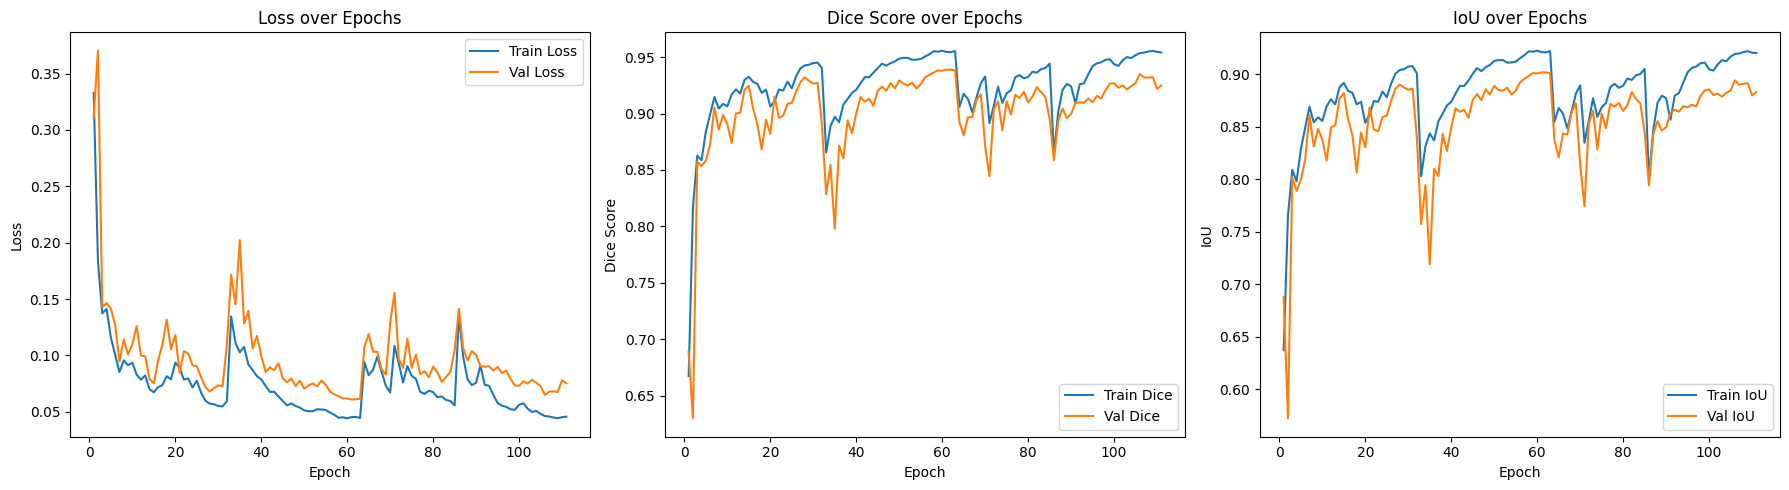

In [62]:
# Plotting
epochs_range = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(18, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, valid_loss_list, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Dice score plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice_list, label='Train Dice')
plt.plot(epochs_range, valid_dice_list, label='Val Dice')
plt.title('Dice Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

# IoU plot
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_iou_list, label='Train IoU')
plt.plot(epochs_range, valid_iou_list, label='Val IoU')
plt.title('IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
# # Initialize model
# model = DeepLabV3Plus(num_classes_seg=2, num_classes_cls=2, mode=1).to(DEVICE)

# Load best weights
model.load_state_dict(torch.load('Seg_RetinaVessel_ColorFundus.pth', map_location=DEVICE))
print("✅ Loaded best model weights")

# Set to evaluation mode
model.eval()

# Create test loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Metrics
metrics = [
    DiceCoefficient(threshold=0.5),
    IoU(threshold=0.5),
    AUC(),
    Accuracy(threshold=0.5),
    Precision(threshold=0.5),
    Recall(threshold=0.5),
    F1Score(threshold=0.5),
]

# Initialize accumulators
test_stats = {metric.__name__: 0.0 for metric in metrics}
test_loss = 0.0
total_samples = 0

# Evaluation loop
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        preds = model(images)

        # Loss
        loss = loss_fn(preds, masks)
        test_loss += loss.item() * images.size(0)

        # Metrics
        for metric in metrics:
            test_stats[metric.__name__] += metric(preds, masks).item() * images.size(0)

        total_samples += images.size(0)

# Average everything
test_loss /= total_samples
for key in test_stats:
    test_stats[key] /= total_samples

# Print results
print("\n📊 Test Evaluation Results:")
print(f"  Loss: {test_loss:.4f}")
for key, value in test_stats.items():
    print(f"  {key}: {value:.4f}")
print(f"\nTotal training time: {elapsed_time / 60:.2f} minutes")

✅ Loaded best model weights

📊 Test Evaluation Results:
  Loss: 0.0608
  DiceCoefficient: 0.9392
  IoU: 0.8987
  AUC: 0.9847
  Accuracy: 0.9743
  Precision: 0.9417
  Recall: 0.9493
  F1Score: 0.9398

Total training time: 41.70 minutes


In [64]:
# # Visualization on test set
# test_dataset_vis = MyDataGenerator(test_df, select_class_rgb_values)  # No transforms for visualization
# test_loader_vis = DataLoader(test_dataset, batch_size=1, shuffle=False)

# model.load_state_dict(torch.load("/kaggle/working/Combined.pth"))
# model.eval()

# sample_preds_folder = 'sample_predictions/'
# os.makedirs(sample_preds_folder, exist_ok=True)

# max_samples = 20

# for idx, (image, gt_mask) in enumerate(test_dataset):
#     if idx >= max_samples:
#         break

#     image_vis = test_dataset_vis[idx][0].astype('uint8')
#     true_dims = image_vis.shape[:2]

#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     pred_mask = model(x_tensor).detach().squeeze().cpu().numpy()
#     pred_mask = np.transpose(pred_mask, (1, 2, 0))

#     pred_mask_argmax = np.argmax(pred_mask, axis=-1)
#     pred_mask_grayscale = (pred_mask_argmax > 0).astype(np.uint8) * 255

#     if pred_mask_grayscale.shape != true_dims:
#         pred_mask_grayscale = cv2.resize(pred_mask_grayscale, (true_dims[1], true_dims[0]), interpolation=cv2.INTER_NEAREST)

#     pred_mask_color = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
#     if pred_mask_color.shape[:2] != true_dims:
#         pred_mask_color = cv2.resize(pred_mask_color, (true_dims[1], true_dims[0]), interpolation=cv2.INTER_NEAREST)

#     gt_mask = np.transpose(gt_mask, (1, 2, 0))
#     gt_mask_argmax = np.argmax(gt_mask, axis=-1)
#     gt_mask_grayscale = (gt_mask_argmax > 0).astype(np.uint8) * 255

#     if gt_mask_grayscale.shape != true_dims:
#         gt_mask_grayscale = cv2.resize(gt_mask_grayscale, (true_dims[1], true_dims[0]), interpolation=cv2.INTER_NEAREST)

#     gt_mask_color = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
#     if gt_mask_color.shape[:2] != true_dims:
#         gt_mask_color = cv2.resize(gt_mask_color, (true_dims[1], true_dims[0]), interpolation=cv2.INTER_NEAREST)

#     vis_img = np.hstack([image_vis, gt_mask_color, pred_mask_color])[:, :, ::-1]
#     cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), vis_img)

#     _, gt_binary = cv2.threshold(gt_mask_grayscale, 127, 1, cv2.THRESH_BINARY)
#     _, pred_binary = cv2.threshold(pred_mask_grayscale, 127, 1, cv2.THRESH_BINARY)

#     if gt_binary.shape != pred_binary.shape:
#         gt_binary = cv2.resize(gt_binary.astype(np.uint8), (pred_binary.shape[1], pred_binary.shape[0]), interpolation=cv2.INTER_NEAREST)

#     tp = np.logical_and(pred_binary, gt_binary)
#     tn = np.logical_and(~pred_binary, ~gt_binary)
#     fp = np.logical_and(pred_binary, ~gt_binary)
#     fn = np.logical_and(~pred_binary, gt_binary)

#     vis_overlay = np.zeros((true_dims[0], true_dims[1], 3), dtype=np.uint8)
#     vis_overlay[tp] = [255, 0, 0]       # Blue for TP
#     vis_overlay[fp & ~tp] = [0, 255, 0] # Green for FP
#     vis_overlay[tn & ~fp & ~tp] = [0, 0, 255] # Red for TN
#     vis_overlay[fn & ~tp & ~fp] = [0, 255, 255] # Yellow for FN

#     cv2.imwrite(os.path.join(sample_preds_folder, f"tp_tn_fp_fn_{idx}.png"), vis_overlay)

#     vis_overlay_rgb = cv2.cvtColor(vis_overlay, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(20, 5))

#     plt.subplot(1, 4, 1)
#     plt.title("Original Image")
#     plt.imshow(image_vis)
#     plt.axis('off')

#     plt.subplot(1, 4, 2)
#     plt.title("Ground Truth")
#     plt.imshow(gt_mask_color)
#     plt.axis('off')

#     plt.subplot(1, 4, 3)
#     plt.title("Predicted Mask")
#     plt.imshow(pred_mask_color)
#     plt.axis('off')

#     plt.subplot(1, 4, 4)
#     plt.title("Overlay")
#     plt.imshow(vis_overlay_rgb)
#     plt.axis('off')

#     plt.show()

# Prediction on Single Image

In [65]:
# import os
# import cv2
# import numpy as np
# import torch
# from matplotlib import pyplot as plt

# # Define DEVICE
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# # Define your model (make sure this matches how you defined it before)
# model = DeepLabV3Plus(num_num_classes_seg_seg=2, num_num_classes_seg_cls=2, mode=1).to(DEVICE)

# # Load weights
# weight_path = "/kaggle/input/cxr-weights/Seg_Lung_CXR.pth"
# model.load_state_dict(torch.load(weight_path, map_location=DEVICE))
# model.eval()

# print("Model loaded and set to evaluation mode.")

In [66]:
# # One-hot encoding and decoding
# def one_hot_encode(label, label_values):
#     semantic_map = []
#     for colour in label_values:
#         equality = np.equal(label, colour)
#         class_map = np.all(equality, axis=-1)
#         semantic_map.append(class_map)
#     return np.stack(semantic_map, axis=-1)

# def reverse_one_hot(image):
#     return np.argmax(image, axis=-1)

# def colour_code_segmentation(image, label_values):
#     colour_codes = np.array(label_values)
#     return colour_codes[image.astype(int)]

In [67]:
# def to_tensor(x, **kwargs):
#     return x.transpose(2, 0, 1).astype('float32')

# def get_preprocessing():
#     return album.Compose([
#         album.Resize(height=256, width=256, always_apply=True),  # Resize to 256x256
#         album.Lambda(image=to_tensor, mask=to_tensor)  # Convert to tensor
#     ])

In [68]:
# import os
# import cv2
# import numpy as np
# import torch
# from matplotlib import pyplot as plt

# def predict_mask_for_single_image(image_path, model, preprocessing_fn, target_size=(256, 256), device='cuda'):
#     """
#     Predicts a binary segmentation mask for a single image.
#     Resizes the image in-memory to target_size before processing.
#     Returns the original-size image and predicted grayscale mask.
#     """
#     # Load image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     orig_dims = image.shape[:2]  # HxW (original size)

#     # Resize in-memory to model input size
#     resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

#     # Apply preprocessing
#     preprocessed = preprocessing_fn(image=resized_image)
#     image_tensor = torch.from_numpy(preprocessed['image']).unsqueeze(0).to(device)

#     # Inference
#     model.eval()
#     with torch.no_grad():
#         output = model(image_tensor).cpu().numpy()

#     # Remove batch and transpose to HxWxC
#     pred_mask = np.transpose(output[0], (1, 2, 0))

#     # Argmax to get predicted class indices
#     pred_mask_argmax = np.argmax(pred_mask, axis=-1)

#     # Convert to binary grayscale mask (class 1 is foreground)
#     pred_mask_grayscale = (pred_mask_argmax > 0).astype(np.uint8) * 255

#     # Resize back to original dimensions if needed
#     if pred_mask_grayscale.shape != orig_dims:
#         pred_mask_grayscale = cv2.resize(
#             pred_mask_grayscale,
#             (orig_dims[1], orig_dims[0]),  # (width, height)
#             interpolation=cv2.INTER_NEAREST
#         )

#     return image, pred_mask_grayscale

In [69]:
# import numpy as np

# # Define RGB values for each class
# select_class_rgb_values = np.array([
#     [0, 0, 0],         # Class 0: Background (Black)
#     [255, 255, 255]    # Class 1: Lung / Lesion (White)
# ])

# model = model.to(DEVICE)

In [70]:
# # Path to your image
# single_image_path = "/kaggle/working/tb-cxr-resized/test/Normal/Normal-1.png"

# # Run prediction
# image, pred_grayscale = predict_mask_for_single_image(
#     image_path=single_image_path,
#     model=model,
#     preprocessing_fn=get_preprocessing(),
#     device=DEVICE
# )

# # Visualize
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title("Input Image")
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Predicted Grayscale Mask")
# plt.imshow(pred_grayscale, cmap='gray')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# Predict mask for dataset

In [71]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # Define source and target directories
# source_root = '/kaggle/working/tb-cxr-resized'
# target_root = '/kaggle/working/Segmented_CXR_Masks'

# # Counter for visualization every 200 images
# counter = 0

# # Traverse the dataset structure
# for split in ['train', 'test']:
#     for label in ['Normal', 'Tuberculosis']:
#         source_dir = os.path.join(source_root, split, label)
#         target_dir = os.path.join(target_root, split, label)
#         os.makedirs(target_dir, exist_ok=True)

#         for filename in tqdm(os.listdir(source_dir), desc=f"{split}/{label}"):
#             if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 continue

#             image_path = os.path.join(source_dir, filename)
#             save_path = os.path.join(target_dir, filename)

#             try:
#                 # Predict mask using your provided function
#                 image, pred_grayscale = predict_mask_for_single_image(
#                     image_path=image_path,
#                     model=model,
#                     preprocessing_fn=get_preprocessing(),
#                     device=DEVICE
#                 )

#                 # Ensure pred_grayscale is in [0, 1], then scale to [0, 255]
#                 pred_grayscale = np.clip(pred_grayscale, 0, 1)  # safety clamp
#                 pred_uint8 = (pred_grayscale * 255).astype(np.uint8)

#                 # Squeeze extra dimensions (e.g., (1, H, W, 1) -> (H, W))
#                 pred_uint8 = np.squeeze(pred_uint8)

#                 # Final sanity check
#                 if np.all(pred_uint8 == 0):
#                     print(f"Empty mask generated for {filename}")

#                 # Save mask as grayscale image
#                 cv2.imwrite(save_path, pred_uint8)

#                 # Visualize every 200th image
#                 counter += 1
#                 if counter % 200 == 0:
#                     plt.figure(figsize=(10, 5))

#                     plt.subplot(1, 2, 1)
#                     plt.title("Input Image")
#                     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Show RGB
#                     plt.axis('off')

#                     plt.subplot(1, 2, 2)
#                     plt.title("Predicted Grayscale Mask")
#                     plt.imshow(pred_uint8, cmap='gray')
#                     plt.axis('off')

#                     plt.tight_layout()
#                     plt.show()

#             except Exception as e:
#                 print(f"Failed to process {image_path}: {e}")

In [72]:
# import shutil
# import os

# folder_path = '/kaggle/working/Segmented_CXR'

# if os.path.exists(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Deleted the folder and all contents: {folder_path}")
# else:
#     print(f"Folder does not exist: {folder_path}")


In [73]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# # Input and output directories
# image_root = '/kaggle/working/tb-cxr-resized'
# mask_root = '/kaggle/working/Segmented_CXR_Masks'
# output_root = '/kaggle/working/Segmented_CXR_Dataset'

# global_counter = 0

# for split in ['train', 'test']:
#     for label in ['Normal', 'Tuberculosis']:
#         image_dir = os.path.join(image_root, split, label)
#         mask_dir = os.path.join(mask_root, split, label)
#         output_dir = os.path.join(output_root, split, label)
#         os.makedirs(output_dir, exist_ok=True)

#         for filename in tqdm(os.listdir(image_dir), desc=f"{split}/{label}"):
#             if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 continue

#             image_path = os.path.join(image_dir, filename)
#             mask_path = os.path.join(mask_dir, filename)
#             save_path = os.path.join(output_dir, filename)

#             if not os.path.exists(mask_path):
#                 print(f"Mask not found for: {filename}")
#                 continue

#             # Load image and mask
#             image = cv2.imread(image_path)
#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#             if image is None or mask is None:
#                 print(f"Failed to read image or mask for {filename}")
#                 continue

#             # Resize mask to match image shape if needed
#             if mask.shape != image.shape[:2]:
#                 mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

#             # Convert mask to binary
#             _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
#             binary_mask = (binary_mask > 0).astype(np.uint8)

#             # Optional: Invert mask if it appears inverted
#             # binary_mask = 1 - binary_mask

#             # Optional: Clean up small holes using morphological closing
#             kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#             binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

#             # Check if mask is empty
#             if np.all(binary_mask == 0):
#                 print(f"Empty mask for {filename}. Skipping.")
#                 continue

#             # Apply mask to each channel
#             segmented = cv2.bitwise_and(image, image, mask=binary_mask)

#             # Save segmented image
#             cv2.imwrite(save_path, segmented)

#             # Also save binary mask for debugging
#             mask_debug_path = save_path.replace(".jpg", "_mask.jpg").replace(".jpeg", "_mask.jpg").replace(".png", "_mask.png")
#             cv2.imwrite(mask_debug_path, binary_mask * 255)

#             # Visualize every 200th image
#             global_counter += 1
#             if global_counter % 200 == 0:
#                 plt.figure(figsize=(12, 4))

#                 plt.subplot(1, 3, 1)
#                 plt.title("Original Image")
#                 plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#                 plt.axis('off')

#                 plt.subplot(1, 3, 2)
#                 plt.title("Predicted Mask")
#                 plt.imshow(mask, cmap='gray')
#                 plt.axis('off')

#                 plt.subplot(1, 3, 3)
#                 plt.title("Segmented CXR")
#                 plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
#                 plt.axis('off')

#                 plt.tight_layout()
#                 plt.show()

In [74]:
# import shutil
# import os

# source_dir = '/kaggle/working/Segmented_CXR_Dataset'
# zip_path = '/kaggle/working/Segmented_CXR_Dataset.zip'

# # Remove existing zip file if it exists (optional safety)
# if os.path.exists(zip_path):
#     os.remove(zip_path)

# # Create zip archive
# shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=source_dir)

# print(f"✅ Zipped successfully to: {zip_path}")